#Pacotes

In [ ]:
pip install catboost shap

In [ ]:
#Tratamento de dados
import numpy as np
import pandas as pd
#Graficos
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
import shap

#Machine Learning
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import scipy
#texto
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LassoLars
import warnings
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Dados


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/house_prices/train.csv')
test = pd.read_csv('/content/drive/MyDrive/house_prices//test.csv')

In [ ]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


#Limpeza


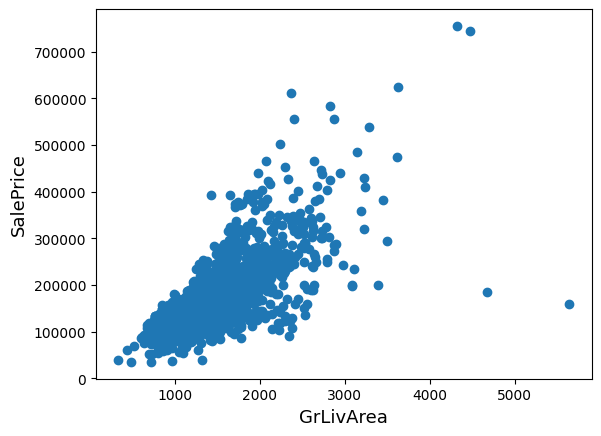

In [ ]:
#verificar outliers
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [ ]:
#total
df_total = pd.concat((train, test)).reset_index(drop=True)

In [ ]:
#verificar tipo de colunas
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [ ]:
#nulos
df_na = (df_total.isnull().sum() / len(df_total)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
df_na = pd.DataFrame({'Perc. N/A' :df_na})
df_na.head(20)

,Perc. N/A
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
MasVnrType,60.500171
SalePrice,49.982871
FireplaceQu,48.646797
LotFrontage,16.649538
GarageCond,5.447071
GarageYrBlt,5.447071


In [ ]:
#tratamentos N/As, Null = None
replace_list = ['MasVnrType','BsmtExposure','BsmtFinType1','PoolQC',
'MiscFeature','Utilities','BsmtFinType2','FireplaceQu','GarageType',
'GarageFinish','GarageCond','Functional','MSZoning','BsmtQual']
for col in replace_list:
    df_total[col] = df_total[col].fillna('None')
df_total["Alley"] = df_total["Alley"].fillna("None")
df_total["Fence"] = df_total["Fence"].fillna("None")
df_total["FireplaceQu"] = df_total["FireplaceQu"].fillna("None")
df_total['MSSubClass'] = df_total['MSSubClass'].fillna("None")

#nulo = 0
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF','MasVnrArea',
'BsmtFullBath', 'BsmtHalfBath','GarageYrBlt', 'GarageArea', 'GarageCars'):
    df_total[col] = df_total[col].fillna(0)

#Substituir pela mediana
#Group by neighborhood e substituir os N/A's de LotFrontage dos neighborhood
df_total["LotFrontage"] = (df_total.groupby("Neighborhood")["LotFrontage"]
.transform(lambda x: x.fillna(x.median())))

#substituir pela moda
df_total['Electrical'] = df_total['Electrical'].fillna(df_total['Electrical'].mode()[0])
df_total['KitchenQual'] = df_total['KitchenQual'].fillna(df_total['KitchenQual'].mode()[0])
df_total['Exterior1st'] = df_total['Exterior1st'].fillna(df_total['Exterior1st'].mode()[0])
df_total['Exterior2nd'] = df_total['Exterior2nd'].fillna(df_total['Exterior2nd'].mode()[0])
df_total['SaleType'] = df_total['SaleType'].fillna(df_total['SaleType'].mode()[0])
df_total['BsmtCond'] = df_total['BsmtCond'].fillna(df_total['BsmtCond'].mode()[0])
df_total['GarageQual'] = df_total['GarageQual'].fillna(df_total['GarageQual'].mode()[0])

#nulos
df_na = (df_total.isnull().sum() / len(df_total)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
df_na = pd.DataFrame({'Perc. N/A' :df_na})
df_na.head(20)

,Perc. N/A
SalePrice,49.982871


In [ ]:
#Transformar numericas em categoricas (Pois nao sao lineares)
df_total['MSSubClass'] = df_total['MSSubClass'].apply(str)
df_total['OverallCond'] = df_total['OverallCond'].astype(str)
df_total['YrSold'] = df_total['YrSold'].astype(str)
df_total['MoSold'] = df_total['MoSold'].astype(str)
df_total['MasVnrArea'] = df_total['MasVnrArea'].astype('float')

In [ ]:
#criar lista de colunas categoricas
colunas_cat = df_total.select_dtypes(include=['object']).columns.tolist()
#criar coluna concat texto
df_total['texto'] = df_total[colunas_cat].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [ ]:
#area total
df_total['TotalSF'] = df_total['TotalBsmtSF'] + df_total['1stFlrSF'] + df_total['2ndFlrSF']
#Calculate Total banheiros
df_total['TotalBath'] = (df_total['FullBath'] + df_total['HalfBath']*0.5 +
df_total['BsmtFullBath'] + df_total['BsmtHalfBath'] * 0.5)

In [ ]:
#dividir novamente os dados
df_train = df_total[df_total['SalePrice'].notnull()]
df_subm = df_total[df_total['SalePrice'].isnull()]

#Pipeline

In [ ]:
#vect
vectorizer = TfidfVectorizer()
#dividir novamente os dados
df_train = df_total[df_total['SalePrice'].notnull()]
colunas_cat = df_train.select_dtypes(include=['object']).drop(columns=['texto']).columns.tolist()
df_train = pd.get_dummies(df_train, columns=colunas_cat)
df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=42)
df_train = df_train.drop(df_train[(df_train['GrLivArea']>3000) & (df_train['SalePrice']<400000)].index)

#treino
colunas_numericas = df_train.select_dtypes(include=['int', 'float']).columns.tolist()
X_train = (df_train[colunas_numericas]).drop(columns=['SalePrice']).values
X_text = vectorizer.fit_transform(df_train['texto'])
X_train_ = scipy.sparse.hstack((X_text, X_train))
y_train_ = df_train['SalePrice']

#teste
X_test = (df_test[colunas_numericas]).drop(columns=['SalePrice']).values
X_text = vectorizer.transform(df_test['texto'])
X_test_ = scipy.sparse.hstack((X_text, X_test))
y_test_ = df_test['SalePrice']

from sklearn.linear_model import (ARDRegression, BayesianRidge, ElasticNet, ElasticNetCV, HuberRegressor, Lars,LarsCV, Lasso, LassoCV, LassoLars, LassoLarsCV, LassoLarsIC, LinearRegression,
OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV, PassiveAggressiveRegressor,PoissonRegressor, QuantileRegressor, RANSACRegressor,
Ridge, RidgeCV, SGDRegressor, TheilSenRegressor)
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
HistGradientBoostingRegressor, RandomForestRegressor, StackingRegressor, VotingRegressor)
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.cross_decomposition import CCA, PLSCanonical, PLSRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.dummy import DummyRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import (ARDRegression, BayesianRidge, ElasticNet, ElasticNetCV, HuberRegressor, Lars,
LarsCV, Lasso, LassoCV, LassoLars, LassoLarsCV, LassoLarsIC, LinearRegression,
    OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV, PassiveAggressiveRegressor,
    PoissonRegressor, QuantileRegressor, RANSACRegressor, Ridge, RidgeCV, SGDRegressor, TheilSenRegressor,
    MultiTaskElasticNet, MultiTaskElasticNetCV, MultiTaskLasso, MultiTaskLassoCV)
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor)
from sklearn.linear_model import (ARDRegression, BayesianRidge, ElasticNet, ElasticNetCV, HuberRegressor, Lars,
LarsCV, Lasso, LassoCV, LassoLars, LassoLarsCV, LassoLarsIC, LinearRegression,
OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV, PassiveAggressiveRegressor,
PoissonRegressor, QuantileRegressor, RANSACRegressor, Ridge, RidgeCV, SGDRegressor, TheilSenRegressor,
MultiTaskElasticNet, MultiTaskElasticNetCV, MultiTaskLasso, MultiTaskLassoCV)
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import (
    AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
    HistGradientBoostingRegressor, RandomForestRegressor, StackingRegressor, VotingRegressor
)
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.cross_decomposition import CCA, PLSCanonical, PLSRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.dummy import DummyRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.compose import TransformedTargetRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.experimental import enable_iterative_imputer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import GammaRegressor, TweedieRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor



#Pipeline completo
models = [
    ('gradient_boost', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=7, random_state=42)),
    ('catboost', CatBoostRegressor(iterations=200, depth=7, random_state=42, verbose=False) ),
    ('transform_target', TransformedTargetRegressor(regressor=CatBoostRegressor(iterations=200, depth=7, random_state=42, verbose=False), func=np.log1p, inverse_func=np.expm1)),
    ('gem', GammaRegressor()),
    ('ada', AdaBoostRegressor()),
    ('bag', BaggingRegressor()),
    ('tree', DecisionTreeRegressor()),
    ('dummy', DummyRegressor()),
    ('elastic', ElasticNet()),
    ('transform_target', TransformedTargetRegressor(regressor=ElasticNet(), func=np.log1p, inverse_func=np.expm1)),
    ('elastic_cv', ElasticNetCV()),
    ('extra_tree', ExtraTreeRegressor()),
    ('extra_trees', ExtraTreesRegressor()),
    ('knn', KNeighborsRegressor()),
    ('lasso', Lasso()),
    ('lasso_cv', LassoCV()),
    ('lasso_lars', LassoLars()),
   ('transform_target', TransformedTargetRegressor(regressor=LassoLars(), func=np.log1p, inverse_func=np.expm1)),
    ('lasso_lars_cv', LassoLarsCV()),
    ('lasso_lars_ic', LassoLarsIC()),
    ('linear_svr', LinearSVR()),
    ('mlp', MLPRegressor()),
    ('pass_agg', PassiveAggressiveRegressor()),
    ('poisson', PoissonRegressor()),
    ('transform_target', TransformedTargetRegressor(regressor=PoissonRegressor(), func=np.log1p, inverse_func=np.expm1)),
    ('ridge', Ridge()),
    ('ridge_cv', RidgeCV()),
    ('transform_target', TransformedTargetRegressor(regressor=Ridge(), func=np.log1p, inverse_func=np.expm1)),
    ('tweedie', TweedieRegressor()),
    ('voting', VotingRegressor(estimators=[('lr', LassoLars()), ('ridge', CatBoostRegressor())]))
]

#Loop através dos modelos
for model_name, model in models:
 print(f'----: {model_name}--------')
 X_train = X_train_
 y_train = y_train_
 X_test = X_test_
 y_test = y_test_
 #Criar pipeline com pré-processamento usando StandardScaler
 pipeline = Pipeline([
 ('scaler', StandardScaler(with_mean=False)),
 ('model', model)
 ])
 #treinar o pipeline
 pipeline.fit(X_train.toarray(), y_train)
 #fazer predicoes no conjunto de teste
 previsoes = pipeline.predict(X_test)
 #log
 y_test = np.log1p(y_test)
 previsoes = np.log1p(previsoes)
 #metricas
 mse = mean_absolute_error(y_test, previsoes)
 rmse = mean_squared_error(y_test, previsoes,squared=False)
 r2 = r2_score(y_test, previsoes)
 print("RMSE:", round(rmse,4)) #0.1198

from sklearn.pipeline import Pipeline


----: gradient_boost--------
RMSE: 0.1529
----: catboost--------
RMSE: 0.1299
----: transform_target--------
RMSE: 0.1302
----: gem--------
RMSE: 0.143
----: ada--------
RMSE: 0.1968
----: bag--------
RMSE: 0.1626
----: tree--------
RMSE: 0.2089
----: dummy--------
RMSE: 0.4452
----: elastic--------
RMSE: 0.1399
----: transform_target--------
RMSE: 0.433
----: elastic_cv--------
RMSE: 0.3792
----: extra_tree--------
RMSE: 0.2068
----: extra_trees--------
RMSE: 0.1464
----: knn--------
RMSE: 0.2041
----: lasso--------
RMSE: 0.2597
----: lasso_cv--------
RMSE: 0.1538
----: lasso_lars--------
RMSE: 0.1617
----: transform_target--------
RMSE: 0.433
----: lasso_lars_cv--------
RMSE: 0.1617
----: lasso_lars_ic--------
RMSE: 0.1547
----: linear_svr--------
RMSE: 0.3551
----: mlp--------
RMSE: 1.2199
----: pass_agg--------
RMSE: 0.1467
----: poisson--------
RMSE: 0.1324
----: transform_target--------
RMSE: 0.1283
----: ridge--------
RMSE: 0.2168
----: ridge_cv--------
RMSE: 0.1919
----: transf

#Catboost/LassoLars (Teste)

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

#vect
vectorizer = TfidfVectorizer()
#dividir novamente os dados
df_train = df_total[df_total['SalePrice'].notnull()]
colunas_cat = df_train.select_dtypes(include=['object']).drop(columns=['texto']).columns.tolist()
df_train = pd.get_dummies(df_train, columns=colunas_cat)
df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=42)
#df_train = df_train.drop(df_train[(df_train['GrLivArea']>3000) & (df_train['SalePrice']<400000)].index)

#treino
colunas_numericas = df_train.select_dtypes(include=['int', 'float']).columns.tolist()
X_train = (df_train[colunas_numericas]).drop(columns=['SalePrice']).values
X_text = vectorizer.fit_transform(df_train['texto'])
X_train = scipy.sparse.hstack((X_text, X_train))
y_train = df_train['SalePrice']

#teste
X_test = (df_test[colunas_numericas]).drop(columns=['SalePrice']).values
X_text = vectorizer.transform(df_test['texto'])
X_test = scipy.sparse.hstack((X_text, X_test))
y_test = df_test['SalePrice']

#Modelos base
base_models = [
    ('catboost', CatBoostRegressor(iterations=200, depth=7, random_state=42, verbose=False) ),
    ('elastic', ElasticNet()),
    ('GradientBoostingRegressor', GradientBoostingRegressor()),
    ('transform_target', TransformedTargetRegressor(regressor=Ridge(), func=np.log1p, inverse_func=np.expm1)),
    ('poisson', TransformedTargetRegressor(regressor=PoissonRegressor(), func=np.log1p, inverse_func=np.expm1)),
]

#Regressor final
final_estimator = GradientBoostingRegressor()

#Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=final_estimator,
    passthrough=True
)

#Treinando o modelo de stacking
stacking_regressor.fit(X_train, y_train)

#Fazendo previsões
y_pred = stacking_regressor.predict(X_test)

#Transformação logarítmica
y_test = np.log1p(y_test)
y_pred = np.log1p(y_pred)

#Métricas
mse = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

#Exibir métricas
print("R2:", round(r2,4))
print("MSE:", round(mse,4))
print("RMSE:", round(rmse,4)) #0.1217 (Cat, Transf Ridg,Transf Poi, elastic)

R2: 0.9105
MSE: 0.0892
RMSE: 0.1292


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
import scipy.sparse
import pandas as pd
import numpy as np


#Shap

In [ ]:
# #dados shap
# explainer = shap.TreeExplainer(catboost_model)
# shap_values = explainer(X_train)
# #Gráfico de resumo
# shap.summary_plot(shap_values, X_train, plot_type="bar",max_display=10)

#Modelo Final

In [ ]:
#vect
vectorizer = TfidfVectorizer()
#dividir novamente os dados
df_train = df_total[df_total['SalePrice'].notnull()]
colunas_cat = df_train.select_dtypes(include=['object']).drop(columns=['texto']).columns.tolist()
df_train = pd.get_dummies(df_train, columns=colunas_cat)
df_train = df_train.drop(df_train[(df_train['GrLivArea']>3000) & (df_train['SalePrice']<400000)].index)

#treino
colunas_numericas = df_train.select_dtypes(include=['int', 'float']).columns.tolist()
X_train = (df_train[colunas_numericas]).drop(columns=['SalePrice']).values
X_text = vectorizer.fit_transform(df_train['texto'])
X_train = scipy.sparse.hstack((X_text, X_train))
y_train = df_train['SalePrice']

#teste
df_test = df_subm.copy()
X_test = (df_test[colunas_numericas]).drop(columns=['SalePrice']).values
X_text = vectorizer.transform(df_test['texto'])
X_test = scipy.sparse.hstack((X_text, X_test))

# Modelos base
base_models = [
    ('gradient_boost', GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=7, random_state=42)),
    ('catboost', CatBoostRegressor(iterations=200, depth=7, random_state=42, verbose=False) ),
    ('transform_target', TransformedTargetRegressor(regressor=Ridge(), func=np.log1p, inverse_func=np.expm1)),
]

# Regressor final (pode ser qualquer um dos mencionados; aqui usamos Ridge para simplificar)
final_estimator = GradientBoostingRegressor()

# Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=final_estimator,
    passthrough=True
)

# Treinando o modelo de stacking
stacking_regressor.fit(X_train, y_train)

# Fazendo previsões
previsoes = stacking_regressor.predict(X_test)

#Fazer previsões no conjunto de teste
df_test = (df_test[['Id']]).copy()
df_test['SalePrice'] = previsoes
#salvar
df_test.to_csv('/content/drive/MyDrive/house_prices/previsao.csv',index=False)